1. 實作 條件邏輯，讓資料流程根據條件被導向不同節點。
2. 使用 START 與 END 節點，明確設定流程的起點與終點。
3. 設計多個節點來執行不同的運算（例如：加法、減法）。
4. 建立一個路由節點（router node），用來做決策並控制整體流程的走向。

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [3]:
class AgentState(TypedDict):
    x: int
    y: int
    operation: str  # "add" or "subtract"
    result: int

In [40]:
def op_router_decide_next_node(state: AgentState) -> str:
    """This node will select the next phase"""
    if state["operation"] == "+":
        return "addition_operation"
    
    elif state["operation"] == "-":
        return "subtraction_operation"  

def adder_node(state: AgentState) -> AgentState:
    print("adder")
    state["result"] = state["x"] + state["y"]
    return state

def subtract_node(state: AgentState) -> AgentState:
    print("subtracter")
    state["result"] = state["x"] - state["y"]
    return state

def result_router_decide_next_node(state: AgentState) -> str:
    return "positive_route_operation" if state["result"] >= 0 else "negative_route_operation"

def positive_summary(state: AgentState) -> AgentState:
    print(f"Result is positive: {state['result']}")
    state["result"] = f"positive: {state['result']}"
    return state

def negative_summary(state: AgentState) -> AgentState:
    print(f"Result is negative: {state['result']}")
    state["result"] = f"negative: {state['result']}"
    return state

In [42]:
graph = StateGraph(AgentState)
graph.add_node("add_operation", adder_node)
graph.add_node("sub_operation", subtract_node)
graph.add_node("step_one", lambda state: state)
graph.add_node("positive_operation", positive_summary)
graph.add_node("negative_operation", negative_summary)
graph.add_node("step_two", lambda state: state)

graph.add_edge(START, "step_one")

graph.add_conditional_edges(
    "step_one", 
    op_router_decide_next_node,
    {
        # Edge: Node format
        "addition_operation": "add_operation",
        "subtraction_operation": "sub_operation"
    }
)

graph.add_edge("add_operation", "step_two")
graph.add_edge("sub_operation", "step_two")

graph.add_conditional_edges(
    "step_two", 
    result_router_decide_next_node,
    {
        # Edge: Node format
        "positive_route_operation": "positive_operation",
        "negative_route_operation": "negative_operation"
    }
)

graph.add_edge("positive_operation", END)
graph.add_edge("negative_operation", END)

# 編譯
app = graph.compile()

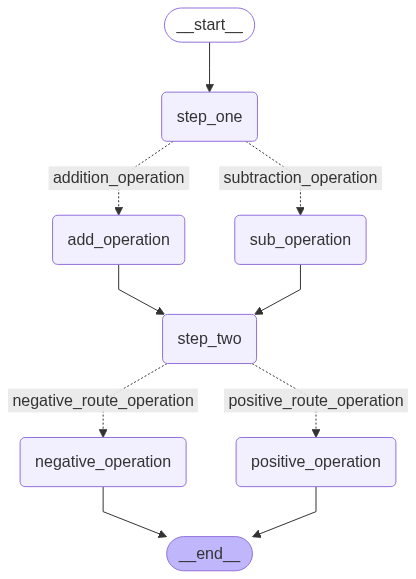

In [43]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [44]:
app.invoke(input={"x": 4, "y": 3, "operation": "+", "result": 0})

adder
Result is positive: 7


{'x': 4, 'y': 3, 'operation': '+', 'result': 'positive: 7'}

In [45]:
app.invoke(input={"x": 1, "y": 3, "operation": "-", "result": 0})

subtracter
Result is negative: -2


{'x': 1, 'y': 3, 'operation': '-', 'result': 'negative: -2'}